<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/Datasets/generateDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
import glob

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
clear_path_list=glob.glob('/content/drive/MyDrive/kitti/gt/*.png')
depth_path_list=glob.glob('/content/drive/MyDrive/kitti/depth_map/*.png')
clear_path_list.sort()
depth_path_list.sort()

In [33]:
airlight=0.76
beta_param=3.912

In [34]:
A=np.zeros((1,1,3))
A[0,0,:]=airlight;


In [35]:
l=[5,10,15,20,25]
visual_range=np.array(l,dtype=float)/1000
#Rgb=PIL.Image.open('/content/drive/MyDrive/gen_test/orig0.png')
#depth_map=PIL.Image.open('/content/drive/MyDrive/gen_test/depth0.png')

In [38]:
def rescale_img(Rgb,depth_map):
  I0=np.asarray(Rgb,dtype=float);
  I0=(I0-I0.min())/(I0.max()-I0.min())
  depth=np.asarray(depth_map,dtype=float);
  depth=(depth-depth.min())/(depth.max()-depth.min())
  d=depth/256;
  return I0,d
  
def srgb2lrgb(I0):
  I=np.power((I0+0.055)/1.055,2.4)
  #I=np.where(I0<=0.04045,I0/12.92,I)
  I[I0<=0.04045] = I0[I0<=0.04045]/12.92;
  return I

def lrgb2srgb(I1):
  I2=np.zeros_like(I1);
  for k in range(0,3):
    temp=I1[:,:,k]
    I2[:,:,k] = 12.92*temp*(temp<=0.0031308)+(1.055*np.power(temp,(1/2.4))-0.055)*(temp>0.0031308);
  return I2

In [26]:
for i in range(len(clear_path_list)):
  rgb=PIL.Image.open(clear_path_list[i])
  depth_map=PIL.Image.open(depth_path_list[i])
  (I0,d)=rescale_img(rgb,depth_map)
  for VR in visual_range:
    

    I=srgb2lrgb(I0)
    d[d==0] = 2*VR;
    beta = [beta_param/VR,beta_param/VR,beta_param/VR];
    beta = np.reshape(beta,(1,1,3));
    transmission = np.exp(-beta*np.expand_dims(d,axis=-1));
    #print(transmission.shape)
    Ic = transmission*I+(1-transmission)*A;
    I2 = lrgb2srgb(Ic);
    plt.imsave(str(i)+'.png',I2)
  break

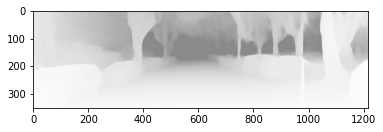

In [ ]:
plt.imshow(transmission)

array([[0.60921766, 0.57858212, 0.56427711, ..., 0.40066283, 0.40066283,
        0.41164515],
       [0.67393632, 0.60591142, 0.57148678, ..., 0.47107125, 0.4325873 ,
        0.44260101],
       [0.69380412, 0.63174362, 0.57504843, ..., 0.41700301, 0.38345809,
        0.38345809],
       ...,
       [0.73664694, 0.73664694, 0.71026448, ..., 0.48009581, 0.48009581,
        0.45234027],
       [0.57148678, 0.61576193, 0.62221801, ..., 0.51830059, 0.53027134,
        0.50177343],
       [0.5532369 , 0.54190876, 0.51423166, ..., 0.54190876, 0.54190876,
        0.52232949]])

In [ ]:
I[88,341,0]

0.00972121732023785

In [ ]:
mask

(array([  0,   0,   0, ..., 351, 351, 351]),
 array([   0,    0,    0, ..., 1215, 1215, 1215]),
 array([0, 1, 2, ..., 0, 1, 2]))

In [ ]:
I[I0<=0.04045] = I0[I0<=0.04045]/12.92;

In [ ]:
j=np.array([[1,3,5,2,8,7],[1,3,5,2,8,7]])

In [ ]:
j[j<3]

array([1, 2, 1, 2])

In [ ]:
np.where(I0<0.045)[2].shape

(9147,)

In [ ]:
I0[0,75,2]

0.00784313725490196

In [ ]:
np.where(I0<0.04,I0/12.92,I)

array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.00151763],
        [0.        , 0.        , 0.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1